In [1]:
#imports
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt
plt.style.use("ggplot")

from src.roc_curve import *

# Logistic Regression

## Basic

### Part 1: Data Exploration: Graduate School Admissions

The data we will be using is admission data on Grad school acceptances.

* `admit`: whether or not the applicant was admitted to grad. school
* `gpa`: undergraduate GPA
* `gre`: score of GRE test
* `rank`: prestige of undergraduate school (1 is highest prestige, ala Harvard)

We will use the GPA, GRE, and rank of the applicants to try to predict whether or not they will be accepted into graduate school.

Before we get to predictions, we should do some data exploration.

1. Load in the dataset into pandas: `data/grad.csv`.

In [2]:
df = pd.read_csv('data/grad.csv')
df.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


2. Use the pandas `describe` method to get some preliminary summary statistics on the data. In particular look at the mean values of the features.

In [3]:
df.describe()

,admit,gre,gpa,rank
count,400.000000,400.000000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,2.48500
std,0.466087,115.516536,0.380567,0.94446
min,0.000000,220.000000,2.260000,1.00000
25%,0.000000,520.000000,3.130000,2.00000
50%,0.000000,580.000000,3.395000,2.00000
75%,1.000000,660.000000,3.670000,3.00000
max,1.000000,800.000000,4.000000,4.00000


3. Use the pandas `crosstab` method to see how many applicants from each rank of school were accepted. You should get a dataframe that looks like this:

    ```
    rank    1   2   3   4
    admit
    0      28  ..  ..  ..
    1      33  ..  ..  ..
    ```

    Make a bar plot of the percent of applicants from each rank who were accepted. You can do `.plot(kind="bar")` on a pandas dataframe.

In [4]:
admit = pd.crosstab(df['admit'], df['rank'], rownames=['admit'])
admit

rank,1,2,3,4
admit,,,,
0,28,97,93,55
1,33,54,28,12


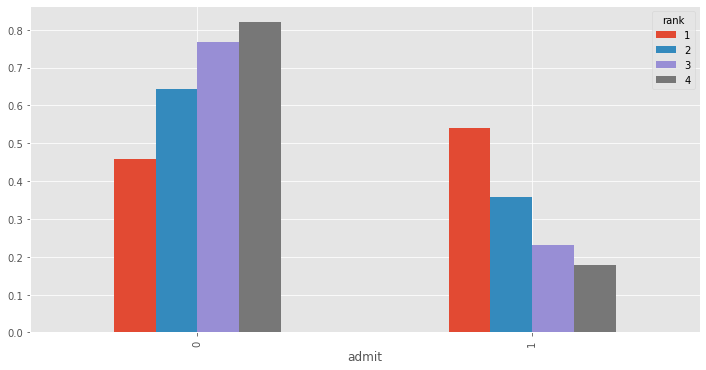

In [5]:
(admit / admit.apply(sum)).plot(kind="bar", figsize=(12, 6));

4. What does the distribution of the GPA and GRE scores look like? Do the distributions differ much?

    Hint: Use the pandas `hist` method.

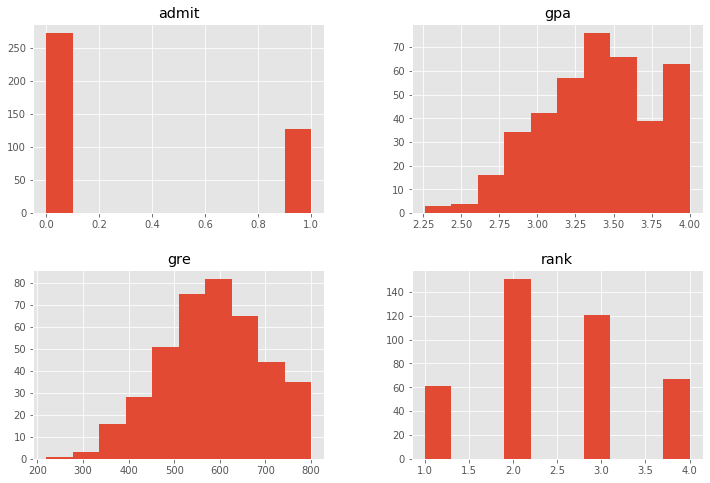

In [6]:
df.hist(figsize=(12, 8));

   *The distributions of GPA and GRE actually look quite similar, possibly normally distributed slightly skewed to the left (negative skew) centered around the means of GPA and GRE computed above. And for GPAs there is an anomolous bump near 4.0s.*

5. One of the issues with classification can be unbalanced classes. What percentage of the data was admitted? Do you think this will be a problem?

In [7]:
df['admit'].value_counts() / len(df)

0    0.6825
1    0.3175
Name: admit, dtype: float64

Classes aren't too imbalanced so you should be fine. When dealing with data where the label could potentially be something that is biased one way or the other (such as acceptance, fraud, signups, anything where one label is more preferential to the other or deals with some measure of "success") you should verify. Actually you should most always verify.

### Part 2: Predicting Graduate School Admissions

Now we're ready to try to fit our data with Logistic Regression.

Look at sklearn's [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) documentation.

1. Use sklearn's [KFold cross validation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) and [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to calculate the average accuracy, precision and recall.

    Hint: Use sklearn's implementation of these scores in [sklearn.metrics](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).


In [8]:
X = df[['gre', 'gpa', 'rank']]
y = df['admit']

In [9]:
kfold = KFold(n_splits=10)

accuracies = []
precisions = []
recalls = []

X_train, X_test, y_train, y_test = train_test_split(X, y)

for train_index, test_index in kfold.split(X_train):
    model = LogisticRegression(solver="lbfgs")
    model.fit(X_train.iloc[train_index], y_train.iloc[train_index])
    y_predict = model.predict(X_train.iloc[test_index])
    y_true = y_train.iloc[test_index]
    accuracies.append(accuracy_score(y_true, y_predict))
    precisions.append(precision_score(y_true, y_predict))
    recalls.append(recall_score(y_true, y_predict))

print("Accuracy:", np.average(accuracies))
print("Precision:", np.average(precisions))
print("Recall:", np.average(recalls))

Accuracy: 0.7066666666666667
Precision: 0.6554761904761904
Recall: 0.30412698412698413


2. The `rank` column is ordinal where we assume an equal change between ranking levels, but we could also consider it to be more generally categorical. Use panda's [get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.core.reshape.get_dummies.html) to binarize the column.

In [10]:
dummies = pd.get_dummies(df['rank'], prefix='rank')
X2 = df[['gre','gpa']].join(dummies.loc[:,'rank_2':])
X2.head()

,gre,gpa,rank_2,rank_3,rank_4
0,380,3.61,0,1,0
1,660,3.67,0,1,0
2,800,4.00,0,0,0
3,640,3.19,0,0,1
4,520,2.93,0,0,1


3. Compute the same metrics as above. Does it do better or worse with the rank column binarized?

    From now on, use the version of the feature matrix that performed the best.

In [11]:
accuracies = []
precisions = []
recalls = []

X2_train, X2_test, y_train, y_test = train_test_split(X2, y)

for train_index, test_index in kfold.split(X2_train):
    model = LogisticRegression(solver="lbfgs", max_iter=500)
    model.fit(X2_train.iloc[train_index], y_train.iloc[train_index])
    y_predict = model.predict(X2_train.iloc[test_index])
    y_true = y_train.iloc[test_index]
    accuracies.append(accuracy_score(y_true, y_predict))
    precisions.append(precision_score(y_true, y_predict))
    recalls.append(recall_score(y_true, y_predict))

print("Accuracy:", np.average(accuracies))
print("Precision:", np.average(precisions))
print("Recall:", np.average(recalls))

Accuracy: 0.6966666666666665
Precision: 0.5966666666666667
Recall: 0.22069597069597066


/Users/danielrupp/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    *It seems to perform worse.*

4. Make a plot of the ROC curve (See notes on ROC curve below).


In [12]:
# plotting helper function
def simple_plot(ax, x, y, x_label, y_label, title):
    ax.plot(x, y)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

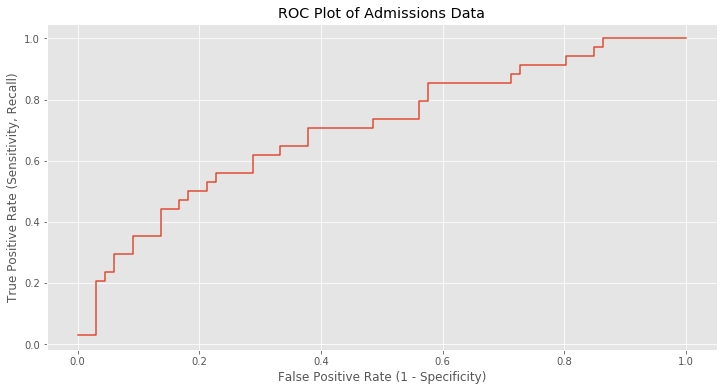

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]
tpr, fpr, thresholds = roc_curve(probabilities, y_test)

fig, ax = plt.subplots(figsize=(12, 6))

simple_plot(ax, fpr, tpr, 
            "False Positive Rate (1 - Specificity)", 
            "True Positive Rate (Sensitivity, Recall)", 
            "ROC Plot of Admissions Data")

5. Is it possible to pick a threshold where TPR > 60% and FPR < 40%? What is the threshold?

    *Note that even if it appears to be in the middle of the graph it doesn't make the threshold 0.5.*




    *Yes. We can get a TPR of 62.5% and FPR of 33.8% with a threshold of 0.3617.*

    *Answers may vary!*

6. Say we are using this as a first step in the application process. We want to weed out clearly unqualified candidates, but not reject too many candidates. What might be a good choice of threshold?

    There isn't a single correct answer, so explain your choice!


    *We want to maximize the TPR and don't care as much about the FPR. With a threshold of 0.222, we can get a TPR of 96.9%. THe FPR will be 73.5%, but we are okay with this sacrifice in order to avoid false negatives.*

## Advanced

### Part 3: Interpreting the beta coefficients with the Odds Ratio

One thing that is often lost when talking about logistic regression is the idea of the odds ratio, or rather the probabilistic interpretation of the model. For this next part we will get hands on with the odds ratio.

The ***odds*** are defined as the product of the exponential of each coefficient.

![](images/odds.gif)

This represents the odds of being admitted over not being admitted.

However, to bring the logistic regression function into the form that resembles a linear predictor, we focus on the logit function known as the logodds.

![](images/logodds.gif)

Note: The base chosen in statistics for the logarithm is traditionally `base e` and the natural logarithm used.

With this transformation, the coefficients of the logistic regression can be interpreted similarly to the coefficients of linear regression; however, they correspond to the change in logodds, which does not have an intuitive meaning.  Luckily, we can calculate the Odds Ratio by exponentiating the beta coefficients

 ![](images/odds_ratio.gif)

The Odds Ratio represents the relative change in odds due to a 1-unit change in the feature.  For instance, the odds that Secratariat will win the Kentucky Derby are 3 times greater when its a dry track than if its been raining.


1. Fit a Logistic Regression model on all the data. What are the beta coefficients? You should have 3 values.

In [14]:
model = LogisticRegression(solver='lbfgs')
model.fit(X, y)

for name, coef in zip(df.columns[1:], model.coef_[0]):
    print("{0}: {1:0.4f}".format(name, coef))

gre: 0.0024
gpa: 0.7012
rank: -0.5499


2. Compute the odds ratio from a one unit change in each feature.



In [15]:
for i, coef in enumerate(model.coef_[0]):
    print("beta{0}: {1:0.5f}".format(i + 1, np.exp(coef)))

beta1: 1.00239
beta2: 2.01611
beta3: 0.57702


3. Write a sentence for each of the three features that sounds like this:

    *Increasing the GPA by 1 point increases the odds by a factor of ??.*

    Make sure you think about each statement. Does it make sense?




    *Increasing the GRE score by 1 point increases the chance of getting in by a factor of 1.00239.*

    *Increasing the GPA score by 1 point increases the chance of getting in by a factor of 2.01611.*

    *Improving the school's rank by 1 point (means decreasing the number) increases the chance of getting in by a factor of 1/0.57702=1.733042.*

4. What change is required to double my chances of admission? Treat each of the features individually.

    e.g. Increasing the GPA by ?? points doubles the odds.

    *Hint: You need to find the value of k in the following equation.*

    ![](images/odds_double.gif)



In [17]:
for i, coef in enumerate(model.coef_[0]):
    print("beta{0}: {1:0.5f}".format(i + 1, np.log(2) / coef))

beta1: 290.72828
beta2: 0.98856
beta3: -1.26054


   *Increasing the GRE score by 290.72828 points doubles the chance of getting in.*

   *Increasing the GPA score by 0.98856 points doubles the chance of getting in.*

   *Decreasing (improving) the school rank by 1.26054 doubles the chance of getting in.*

## Extra Credit

### Part 4: ROC Curves

One of the best ways to evaluate how a classifier performs is an ROC curve. (http://en.wikipedia.org/wiki/Receiver_operating_characteristic)

Look at the documentation for [scikit-learns ROC curve function](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) and its [user guide](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics).

![](images/roc_curve.png)

To understand what is actually happening with an ROC curve, we can create one ourselves.  Here is pseudocode to plot it.

The `probabilities` are values in (0,1) returned from Logistic Regression. The standard default threshold is 0.5 where
0-0.5 values are interpreted as the negative class and 0.5-1 values are predicted as the positive class.

The `labels` are the true values.

```
function ROC_curve(probabilities, labels):
    Sort instances by their prediction strength (the probabilities)
    For every instance in increasing order of probability:
        Set the threshold to be the probability
        Set everything above the threshold to the positive class
        Calculate the True Positive Rate (aka sensitivity or recall)
        Calculate the False Positive Rate (1 - specificity)
    Return three lists: TPRs, FPRs, thresholds
```

Recall that the *true positive rate* is

```
 number of true positives     number correctly predicted positive
-------------------------- = -------------------------------------
 number of positive cases           number of positive cases
```

and the *false positive rate* is

```
 number of false positives     number incorrectly predicted positive
--------------------------- = ---------------------------------------
  number of negative cases           number of negative cases
```

You're going to be implementing the `roc_curve` function.

Here's some example code that you should be able to use to plot the ROC curve with your function. This uses a fake dataset.


```python
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=2, n_samples=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = LogisticRegression()
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]

tpr, fpr, thresholds = roc_curve(probabilities, y_test)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of fake data")
plt.show()
```



1. Write an ROC curve function to compute the above in `roc_curve.py`.

    It should take as input the predicted probabilities and the true labels.

2. Run the above code to verify that it's working correctly. You can also validate your correctness against [scikit-learns built-in function](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html).



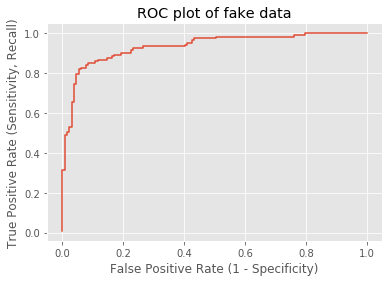

In [18]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           n_clusters_per_class=2, n_samples=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = LogisticRegression()
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]

tpr, fpr, thresholds = roc_curve(probabilities, y_test)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of fake data")
plt.show()

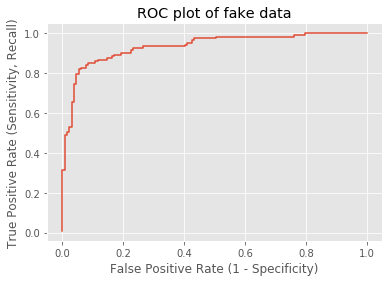

In [19]:
from sklearn.metrics import roc_curve as sklearn_roc_curve

tpr, fpr, thresholds = roc_curve(probabilities, y_test)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of fake data")
plt.show()

3. Let's see how the roc curve looks on a real dataset. We're going to use the FICO Loan dataset. We want to predict whether or not you get approved for a loan of 12% interest rate given the FICO Score, Loan Length and Loan Amount. Here's the code to load the data:

    ```python
    import pandas as pd
    df = pd.read_csv('data/loanf.csv')
    y = (df['Interest.Rate'] <= 12).values
    X = df[['FICO.Score', 'Loan.Length', 'Loan.Amount']].values
    ```

    Make sure to split your data into training and testing using sklearn's [train_test_split()](https://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.train_test_split.html).

In [20]:
import pandas as pd
df = pd.read_csv('data/loanf.csv')
y = (df['Interest.Rate'] <= 12).values
X = df[['FICO.Score', 'Loan.Length', 'Loan.Amount']].values

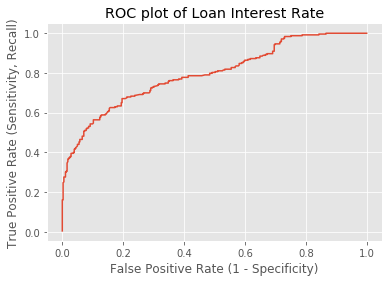

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

model = LogisticRegression()
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]

tpr, fpr, thresholds = roc_curve(probabilities, y_test)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of Loan Interest Rate")
plt.show()